In [1]:
from typing import Dict, Any

from langgraph.graph import StateGraph, MessagesState
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.base import Checkpoint, CheckpointMetadata, ChannelVersions



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

In [4]:
from prompts import prompt_context_question
from config import GOOGLE_GENAI_MODEL


In [5]:
import sqlite3

In [6]:
db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [7]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [8]:
llm = ChatGoogleGenerativeAI(model=GOOGLE_GENAI_MODEL)
parser = StrOutputParser()

In [9]:
def generate(state: MessagesState, config: Dict[str, Any]) -> MessagesState:
    configurable = config.get("configurable", {})
    #vectordb = configurable.get("vectordb")

    messages = state.get("messages", [])
    question = next((msg.content for msg in reversed(messages) if isinstance(msg, HumanMessage)), None)

    context = ""
    if question:
        #docs = vectordb.similarity_search(question, k=4)
        #context = "\n".join(doc.page_content for doc in docs)
        context = "my friends are Rahul and ganesh"
        historical_message = "\n".join(f"{msg.type.capitalize()}: {msg.content}" for msg in messages)
        print("history", historical_message)
        chain = prompt_context_question | llm | parser
        answer = chain.invoke({
                "context": context,
                "history": historical_message,
                "question": question
            })
        print("answer", answer)

        new_messages = messages + [AIMessage(content=answer)]

        print("new_message", new_messages)

        return {"messages": new_messages}

builder = StateGraph(MessagesState)
builder.add_node("generate", generate)
builder.set_entry_point("generate")
builder.set_finish_point("generate")

graph = builder.compile(checkpointer=memory)

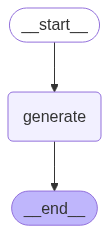

In [10]:
graph

In [19]:
session_id = "47b513aa-14f4-423e-946f-f3a2a9b84e75"

In [20]:
config = {
            "configurable": {
                "thread_id": session_id
            }
        }

In [21]:
user_message = "what is my name"
input_message = HumanMessage(content=user_message)

In [22]:
output = graph.invoke({"messages":[input_message]}, config)

history Human: what is my name
Ai: I do not have access to your name.
Human: my name is ashish
Ai: I understand that your name is Ashish.
Human: what is my name
answer Ashish
new_message [HumanMessage(content='what is my name', additional_kwargs={}, response_metadata={}, id='0fd2af7c-fa35-45c2-8e56-573e0a6d3272'), AIMessage(content='I do not have access to your name.', additional_kwargs={}, response_metadata={}, id='c8c03641-23f8-4921-8770-fb83e9fa9c93'), HumanMessage(content='my name is ashish', additional_kwargs={}, response_metadata={}, id='1f135f6e-bc7b-4213-88d6-361f1926b00d'), AIMessage(content='I understand that your name is Ashish.', additional_kwargs={}, response_metadata={}, id='34199970-a775-489b-8f79-97caffc89a91'), HumanMessage(content='what is my name', additional_kwargs={}, response_metadata={}, id='635bf29a-2d84-4a20-a86e-bd741825220b'), AIMessage(content='Ashish', additional_kwargs={}, response_metadata={})]


In [47]:
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [48]:
a = CustomMessagesState()

In [50]:
type(a)

dict

In [49]:
a

{}